# QPower2 model

The qpower2 model, `pytransit.QPower2Model`, implements a transit over a stellar disk with the stellar limb darkening described using the qpower2 limb darkening model as described by Maxted & Gill (ArXIV:1812.01606). The model is parallelised using numba, and the number of threads can be set using the `NUMBA_NUM_THREADS` environment variable. An OpenCL version for GPU computation is implemented by `pytransit.QPower2ModelCL`.

In [1]:
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [2]:
sys.path.append('..')

In [3]:
from src import QPower2Modelwer2Model

In [4]:
seed(0)

times_sc = linspace(0.85, 1.15, 1000)  # Short cadence time stamps
times_lc = linspace(0.85, 1.15,  100)  # Long cadence time stamps

k, t0, p, a, i, e, w  = 0.1, 1., 2.1, 3.2, 0.5*pi, 0.3, 0.4*pi
pvp = tile([k, t0, p, a, i, e, w], (50,1))
pvp[1:,0] += normal(0.0, 0.005, size=pvp.shape[0]-1)
pvp[1:,1] += normal(0.0, 0.02, size=pvp.shape[0]-1)

ldc = stack([normal(0.3, 0.05, pvp.shape[0]), normal(0.1, 0.02, pvp.shape[0])], 1)

## Model initialization

The qpower2 model doesn't take any special initialization arguments, so the initialization is straightforward. 

In [5]:
tm = QPower2Model()

## Data setup
### Homogeneous time series

The model needs to be set up by calling `set_data()` before it can be used. At its simplest, `set_data` takes the mid-exposure times of the time series to be modelled.

In [6]:
tm.set_data(times_sc)

## Model use

**Evaluation**
The transit model can be evaluated using either a set of scalar parameters, a parameter vector (1D ndarray), or a parameter vector array (2D ndarray). The model flux is returned as a 1D ndarray in the first two cases, and a 2D ndarray in the last (one model per parameter vector).

  - `tm.evaluate_ps(k, ldc, t0, p, a, i, e=0, w=0)` evaluates the model for a set of scalar parameters, where `k` is the radius ratio, `ldc` is the limb darkening coefficient vector, `t0` the zero epoch, `p` the orbital period, `a` the semi-major axis divided by the stellar radius, `i` the inclination in radians, `e` the eccentricity, and `w` the argument of periastron. Eccentricity and argument of periastron are optional, and omitting them defaults to a circular orbit. 
  - `tm.evaluate_pv(pv, ldc)` evaluates the model for a 1D parameter vector, or 2D array of parameter vectors. In the first case, the parameter vector should be array-like with elements `[k, t0, p, a, i, e, w]`. In the second case, the parameter vectors should be stored in a 2d ndarray with shape `(npv, 7)` as 


    [[k1, t01, p1, a1, i1, e1, w1],
     [k2, t02, p2, a2, i2, e2, w2],
     ...
     [kn, t0n, pn, an, in, en, wn]]
     
The reason for the different options is that the model implementations may have optimisations that make the model evaluation for a set of parameter vectors much faster than if computing them separately. This is especially the case for the OpenCL models.

*Note:* PyTransit uses always a 2D parameter vector array under the hood, and the scalar evaluation method just packs the parameters into an array before model evaluation.

**Limb darkening**
The quadratic limb darkening coefficients are given either as a 1D or 2D array, depending on whether the model is evaluated for a single set of parameters or an array of parameter vectors. In the first case, the coefficients can be given as `[u, v]`, and in the second, as `[[u1, v1], [u2, v2], ... [un, vn]]`. 

In the case of a heterogeneous time series with multiple passbands (more details below), the coefficients are given for a single parameter set as a 1D array with a length $2n_{pb}$ (`[u1, v1, u2, v2, ... un, vn]`, where the index now marks the passband), and for a parameter vector array as a 2D array with a shape `(npv, 2*npb)`, as

    [[u11, v11, u12, v12, ... u1n, v1n], 
     [u21, v21, u22, v22, ... u2n, v2n], 
     ...
     [un1, vn1, un2, vn2, ... unn, vnn]]
     

In [6]:
def plot_transits(tm, ldc, fmt='k'):
    fig, axs = subplots(1, 3, figsize = (13,3), constrained_layout=True, sharey=True)

    flux = tm.evaluate_ps(k, ldc[0], t0, p, a, i, e, w)
    axs[0].plot(tm.time, flux, fmt)
    axs[0].set_title('Individual parameters')

    flux = tm.evaluate_pv(pvp[0], ldc[0])
    axs[1].plot(tm.time, flux, fmt)
    axs[1].set_title('Parameter vector')

    flux = tm.evaluate_pv(pvp, ldc)
    axs[2].plot(tm.time, flux.T, 'k', alpha=0.2);
    axs[2].set_title('Parameter vector array')

    setp(axs[0], ylabel='Normalised flux')
    setp(axs, xlabel='Time [days]', xlim=tm.time[[0,-1]])

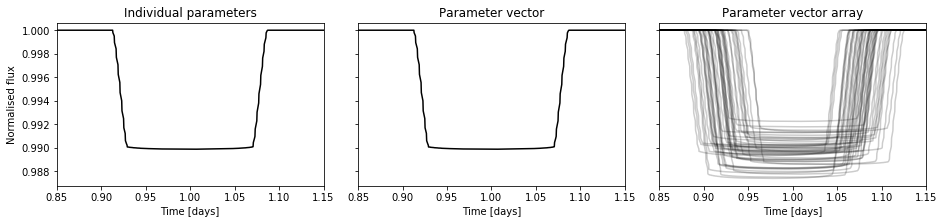

In [7]:
tm.set_data(times_sc)
plot_transits(tm, ldc)

## Supersampling

The transit model can be supersampled by setting the `nsamples` and `exptimes` arguments in `set_data`.

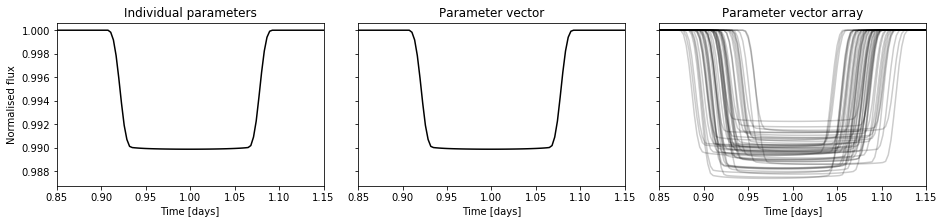

In [8]:
tm.set_data(times_lc, nsamples=10, exptimes=0.01)
plot_transits(tm, ldc)

## Heterogeneous time series

PyTransit allows for heterogeneous time series, that is, a single time series can contain several individual light curves (with, e.g., different time cadences and required supersampling rates) observed (possibly) in different passbands.

If a time series contains several light curves, it also needs the light curve indices for each exposure. These are given through `lcids` argument, which should be an array of integers. If the time series contains light curves observed in different passbands, the passband indices need to be given through `pbids` argument as an integer array, one per light curve. Supersampling can also be defined on per-light curve basis by giving the `nsamples`and `exptimes` as arrays with one value per light curve. 

For example, a set of three light curves, two observed in one passband and the third in another passband

    times_1 (lc = 0, pb = 0, sc) = [1, 2, 3, 4]
    times_2 (lc = 1, pb = 0, lc) = [3, 4]
    times_3 (lc = 2, pb = 1, sc) = [1, 5, 6]
    
Would be set up as

    tm.set_data(time  = [1, 2, 3, 4, 3, 4, 1, 5, 6], 
                lcids = [0, 0, 0, 0, 1, 1, 2, 2, 2], 
                pbids = [0, 0, 1],
                nsamples = [  1,  10,   1],
                exptimes = [0.1, 1.0, 0.1])
                
Further, each passband requires two limb darkening coefficients, so the limb darkening coefficient array for a single parameter set should now be

    ldc = [u1, v1, u2, v2]

where u and v are the passband-specific qpower2 limb darkening model coefficients.

### Example: two light curves with different cadences and passbands

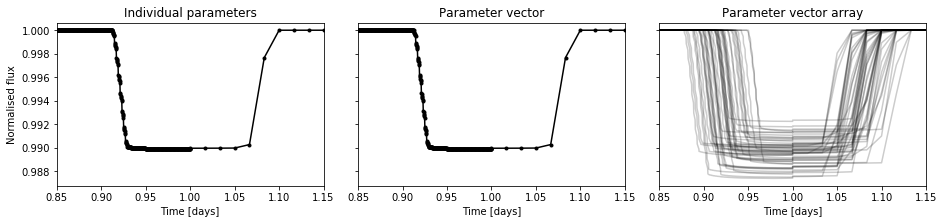

In [9]:
times_1 = linspace(0.85, 1.0, 500)
times_2 = linspace(1.0, 1.15,  10)
times = concatenate([times_1, times_2])
lcids = concatenate([full(times_1.size, 0, 'int'), full(times_2.size, 1, 'int')])
pbids = [0, 1]
nsamples = [1, 10]
exptimes = [0, 0.0167]

ldc2 = tile(ldc, (1,2))
ldc2[:,2:] /= 2

tm.set_data(times, lcids, pbids, nsamples=nsamples, exptimes=exptimes)
plot_transits(tm, ldc2, 'k.-')

---
<center>&copy; Hannu Parviainen 2010-2019</center>